# Neural Networks

In [1]:
import numpy as np
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_circles

import torch
from torch.optim import SGD
from torch import nn

## The data

In [2]:
features, labels = make_circles(100, factor=.1, noise=.1)

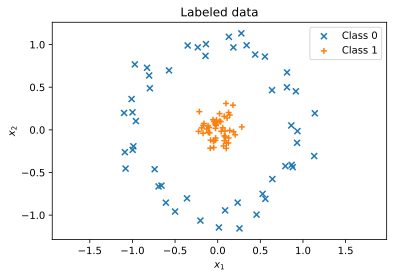

In [3]:
def plot_prediction(features, y_true, y_predicted):
    labels = np.unique(y_true)
    for i, (label, marker) in enumerate(zip(labels, "x+*.")):
        class_data = features[y_true == label]
        # Color is given by the predicted label
        colors = [f"C{predicted - labels.min()}" for predicted in y_predicted[y_true == label]]
        plt.scatter(class_data[:, 0], class_data[:, 1], marker=marker, label=f"Class {label}", c=colors)
    plt.legend()
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("equal")

plt.title("Labeled data")
plot_prediction(features, labels, labels)
x_range = plt.xlim()
y_range = plt.ylim()

## Interactive training with TensorFlow Playground

A [linear classifier](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.97720&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) cannot separate the data.

Can you modify the architecture so that the orange becomes separated from the blue? Check the [solution](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.97720&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

*... or start with a fresh [TensorFlow Playground](https://playground.tensorflow.org/)*

## Build it yourself with PyTorch

In [4]:
def build_model(depth, width):
    models = []
    
    prev_width = 2
    for d in range(depth):
        # Each layer is a linear transformation and a non-linearity
        models.append(nn.Linear(prev_width, width))
        models.append(nn.ReLU())
        prev_width = width
    
    # Final layer computes 2d log-softmax
    models.append(nn.Linear(prev_width, 2))
    models.append(nn.LogSoftmax(1))
    
    return nn.Sequential(*models)

def predict_label(model, x):
    if not torch.is_tensor(x):
        x = torch.tensor(x).float()
    
    with torch.no_grad():
        y_pred = model(x)
        # This computes the argmax of y_pred
        return y_pred.data.sort(1, True)[1][:, 0]


def train_model(model, x, y, epochs, lr=0.03):
    sgd = SGD(model.parameters(), lr=lr)
    loss = nn.NLLLoss()
    
    x = torch.tensor(x).float()
    y = torch.tensor(y)
    
    for epoch in range(epochs):
        sgd.zero_grad()
        
        # Predict and compute loss
        y_pred = model(x)
        loss_value = loss(y_pred, y)
        
        # Run gradient computation
        loss_value.backward()
        sgd.step()
        
        if epoch % 25 == 0:
            hard_pred = predict_label(model, x)
            hard_pred_correct = hard_pred == y
            error = 1 - hard_pred_correct.float().mean().item()
            print(f"Epoch {epoch:3}: Loss {loss_value.item():.2f}, Err {error * 100:.2f}%")

In [5]:
def plot_prediction_grid(x_range, y_range, model, samples=100):
    x, y = torch.meshgrid(torch.linspace(*x_range, samples), torch.linspace(*y_range, samples))
    positions = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).reshape(-1, 2)
    prediction = model(positions)[:, 0].exp().detach().reshape(samples, samples).numpy()
    plt.imshow(prediction.T, origin="lower", extent=(*x_range, *y_range),
               cmap="coolwarm_r", vmin=0, vmax=1, alpha=0.3)
    plt.colorbar(label="Predicted Probability class 0")
    plt.contour(x, y, prediction.reshape(samples, samples), [0.5])

### Linear network (no hidden layer)

Epoch   0: Loss 0.70, Err 70.00%
Epoch  25: Loss 0.69, Err 47.00%
Epoch  50: Loss 0.69, Err 49.00%
Epoch  75: Loss 0.69, Err 48.00%
Epoch 100: Loss 0.69, Err 49.00%
Epoch 125: Loss 0.69, Err 49.00%


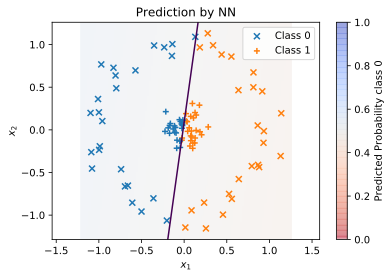

In [6]:
torch.manual_seed(2398)
model = build_model(0, 0)
train_model(model, features, labels, 150, 0.3)

plt.title("Prediction by NN")
plot_prediction(features, labels, predict_label(model, features).numpy())
plot_prediction_grid(x_range, y_range, model)

### One hidden layer

Epoch   0: Loss 0.67, Err 38.00%
Epoch  25: Loss 0.38, Err 8.00%
Epoch  50: Loss 0.08, Err 0.00%
Epoch  75: Loss 0.03, Err 0.00%
Epoch 100: Loss 0.02, Err 0.00%
Epoch 125: Loss 0.01, Err 0.00%


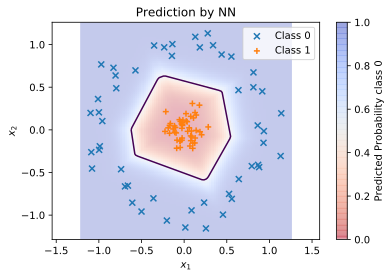

In [7]:
torch.manual_seed(2398)
model = build_model(1, 5)
train_model(model, features, labels, 150, 1.)

plt.title("Prediction by NN")
plot_prediction(features, labels, predict_label(model, features).numpy())
plot_prediction_grid(x_range, y_range, model)